# STCH-BoTorch Demo

This notebook demonstrates the Smooth Tchebycheff (STCH) scalarization methods for multi-objective Bayesian optimization.

## Overview

- **Visual comparison**: TCH vs STCH (showing smoothness)
- **Interactive demo**: Synthetic multi-objective problem
- **BoTorch integration**: Using with acquisition functions
- **Convergence visualization**: How STCH approaches TCH as μ → 0


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Import STCH functions
from stch_botorch import smooth_chebyshev, smooth_chebyshev_set
from stch_botorch import SmoothChebyshevObjective, SmoothChebyshevSetObjective

print("STCH-BoTorch Demo")
print("=" * 50)


STCH-BoTorch Demo


## 1. Visual Comparison: TCH vs STCH

Let's visualize how STCH smooths the non-differentiable "kinks" in TCH.


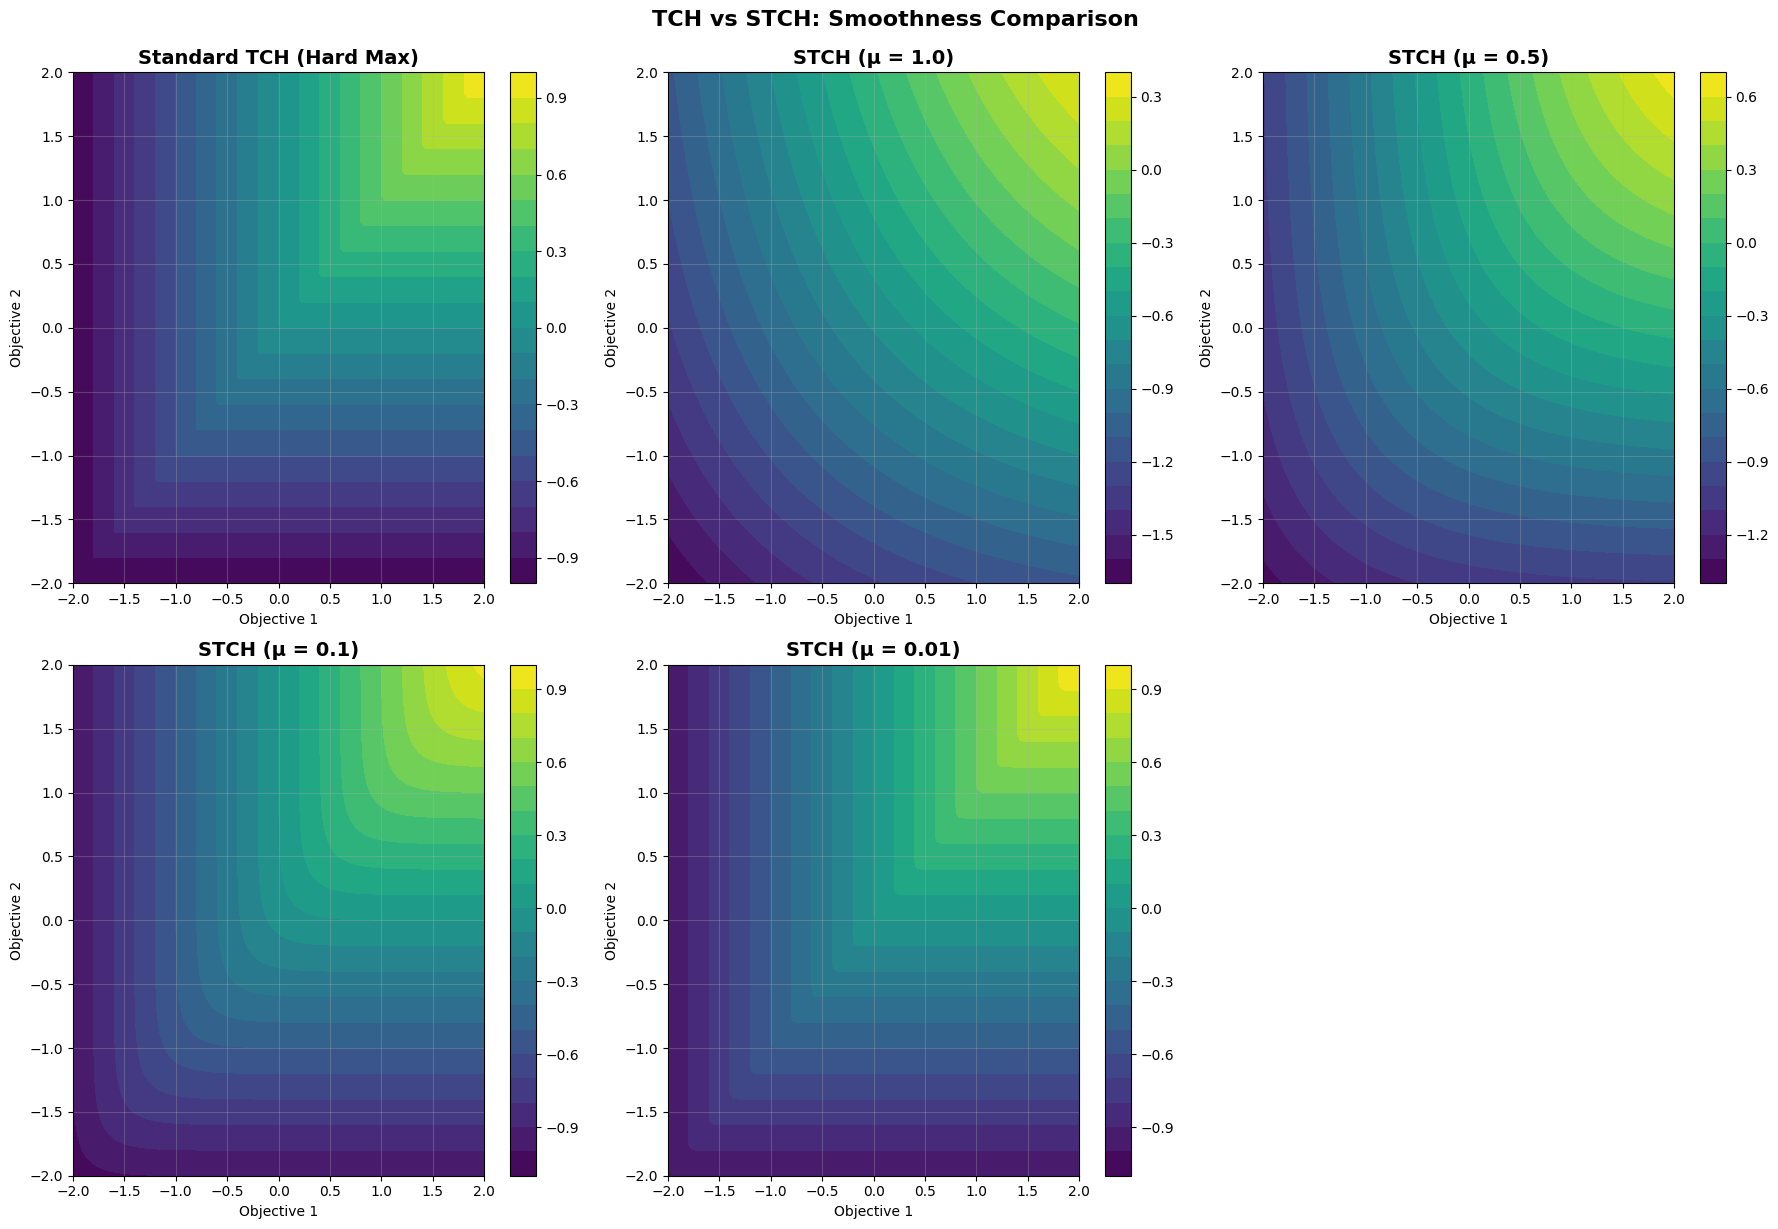

Notice how STCH smooths the sharp 'kinks' in TCH, making it differentiable.


In [10]:
# Create a 2D grid of objective values
y1_range = np.linspace(-2, 2, 100)
y2_range = np.linspace(-2, 2, 100)
Y1, Y2 = np.meshgrid(y1_range, y2_range)

# Convert to torch tensors
Y = torch.tensor(np.stack([Y1, Y2], axis=-1), dtype=torch.float32)
weights = torch.tensor([0.5, 0.5])
ref_point = torch.tensor([0.0, 0.0])

# Compute TCH (hard max)
weighted_distances = weights * (ref_point - Y)
tch_values = -weighted_distances.max(dim=-1)[0].numpy()

# Compute STCH with different mu values
mu_values = [1.0, 0.5, 0.1, 0.01]
stch_results = {}
for mu in mu_values:
    stch_vals = smooth_chebyshev(Y, weights, ref_point, mu=mu)
    stch_results[mu] = stch_vals.numpy()

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# TCH
ax = axes[0]
contour = ax.contourf(Y1, Y2, tch_values, levels=20, cmap='viridis')
ax.set_title('Standard TCH (Hard Max)', fontsize=14, fontweight='bold')
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.grid(True, alpha=0.3)
plt.colorbar(contour, ax=ax)

# STCH with different mu
for idx, mu in enumerate(mu_values, 1):
    ax = axes[idx]
    contour = ax.contourf(Y1, Y2, stch_results[mu], levels=20, cmap='viridis')
    ax.set_title(f'STCH (μ = {mu})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Objective 1')
    ax.set_ylabel('Objective 2')
    ax.grid(True, alpha=0.3)
    plt.colorbar(contour, ax=ax)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('TCH vs STCH: Smoothness Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("Notice how STCH smooths the sharp 'kinks' in TCH, making it differentiable.")


## 2. Convergence: STCH → TCH as μ → 0

Let's verify that STCH converges to TCH as the smoothing parameter approaches zero.


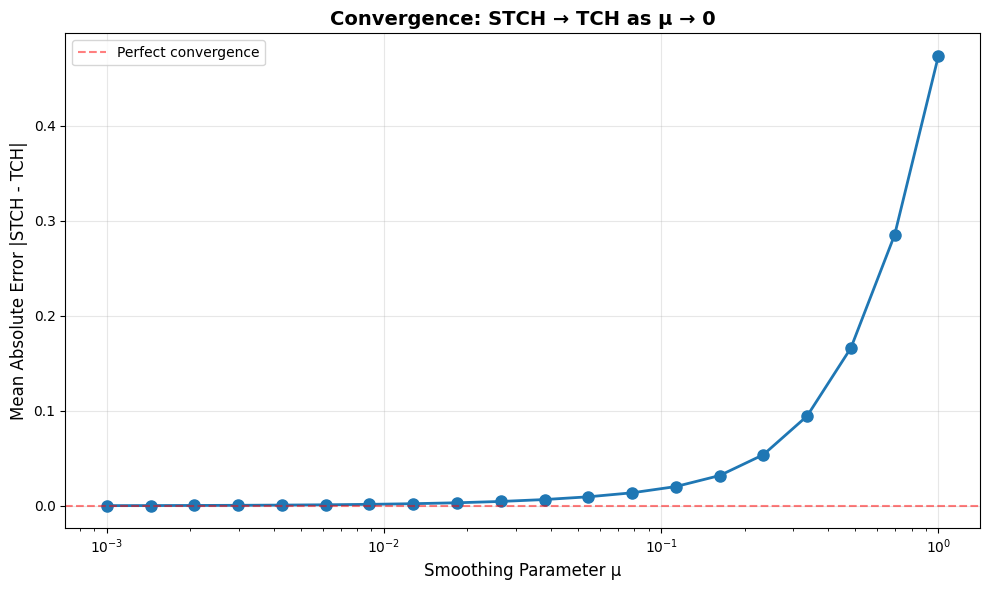

Final error (μ = 0.001000): 0.000173
As μ → 0, STCH converges to TCH!


In [11]:
# Test points
test_points = torch.tensor([
    [1.0, 2.0],
    [2.0, 1.0],
    [1.5, 1.5],
    [0.5, 3.0],
])

weights = torch.tensor([0.5, 0.5])
ref_point = torch.tensor([0.0, 0.0])

# Compute TCH values
weighted_distances = weights * (ref_point - test_points)
tch_values = -weighted_distances.max(dim=-1)[0]

# Compute STCH with decreasing mu
mu_values = np.logspace(0, -3, 20)  # From 1.0 to 0.001
errors = []

for mu in mu_values:
    stch_values = smooth_chebyshev(test_points, weights, ref_point, mu=float(mu))
    error = torch.abs(stch_values - tch_values).mean().item()
    errors.append(error)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.semilogx(mu_values, errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('Smoothing Parameter μ', fontsize=12)
plt.ylabel('Mean Absolute Error |STCH - TCH|', fontsize=12)
plt.title('Convergence: STCH → TCH as μ → 0', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Perfect convergence')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final error (μ = {mu_values[-1]:.6f}): {errors[-1]:.6f}")
print("As μ → 0, STCH converges to TCH!")


## 3. Gradient Comparison: TCH vs STCH

One key advantage of STCH is that it provides gradients for all objectives, not just the worst one.


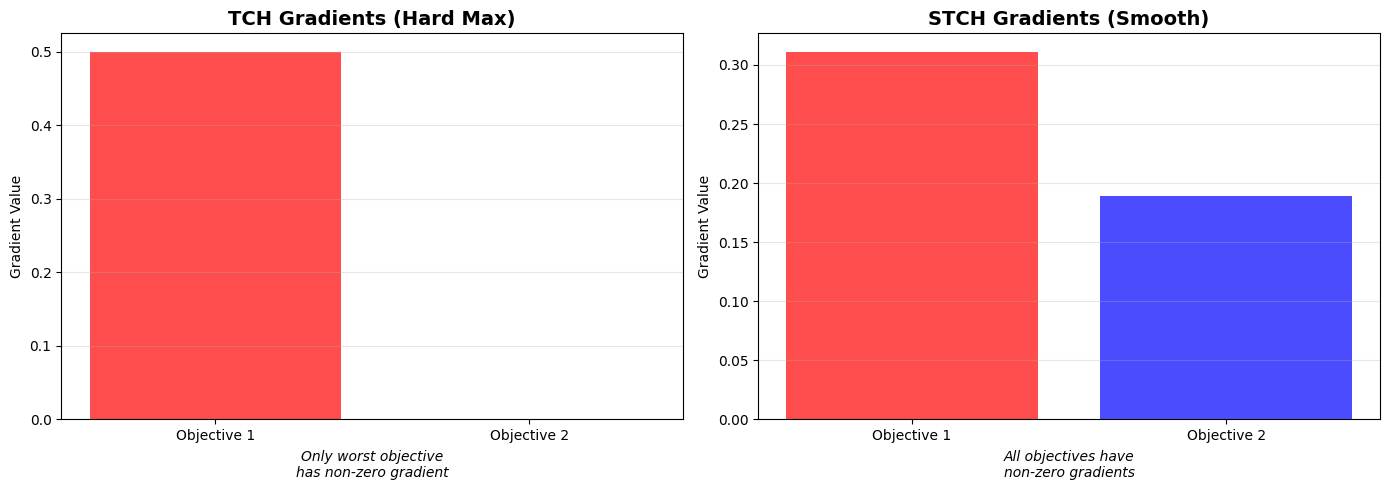

TCH Gradients: [ 0.5 -0. ]
STCH Gradients: [0.3112296 0.1887703]

STCH provides gradients for all objectives, enabling better optimization!


In [12]:
# Create a point where objectives are close (near the "kink")
Y = torch.tensor([[1.0, 1.1]], requires_grad=True)
weights = torch.tensor([0.5, 0.5])
ref_point = torch.tensor([0.0, 0.0])

# TCH gradient (hard max - only one objective has gradient)
Y_tch = Y.clone().detach().requires_grad_(True)
weighted_dist_tch = weights * (ref_point - Y_tch)
tch_val = -weighted_dist_tch.max(dim=-1)[0]
tch_val.backward()
tch_grad = Y_tch.grad.clone()

# STCH gradient (smooth - all objectives have gradients)
Y_stch = Y.clone().detach().requires_grad_(True)
stch_val = smooth_chebyshev(Y_stch, weights, ref_point, mu=0.1)
stch_val.backward()
stch_grad = Y_stch.grad.clone()

# Visualize gradients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# TCH gradients
ax1.bar(['Objective 1', 'Objective 2'], tch_grad[0].numpy(), color=['red', 'blue'], alpha=0.7)
ax1.set_title('TCH Gradients (Hard Max)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Gradient Value')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.grid(True, alpha=0.3, axis='y')
ax1.text(0.5, -0.15, 'Only worst objective\nhas non-zero gradient', 
         ha='center', transform=ax1.transAxes, fontsize=10, style='italic')

# STCH gradients
ax2.bar(['Objective 1', 'Objective 2'], stch_grad[0].numpy(), color=['red', 'blue'], alpha=0.7)
ax2.set_title('STCH Gradients (Smooth)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Gradient Value')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3, axis='y')
ax2.text(0.5, -0.15, 'All objectives have\nnon-zero gradients', 
         ha='center', transform=ax2.transAxes, fontsize=10, style='italic')

plt.tight_layout()
plt.show()

print("TCH Gradients:", tch_grad[0].numpy())
print("STCH Gradients:", stch_grad[0].numpy())
print("\nSTCH provides gradients for all objectives, enabling better optimization!")


## 4. STCH-Set: Batch Optimization

STCH-Set optimizes a batch of candidates to collectively cover all objectives.


STCH (per candidate):
  Candidate 1: 0.5000
  Candidate 2: 0.5000
  Candidate 3: 2.4307

STCH-Set (aggregated): 4.9307


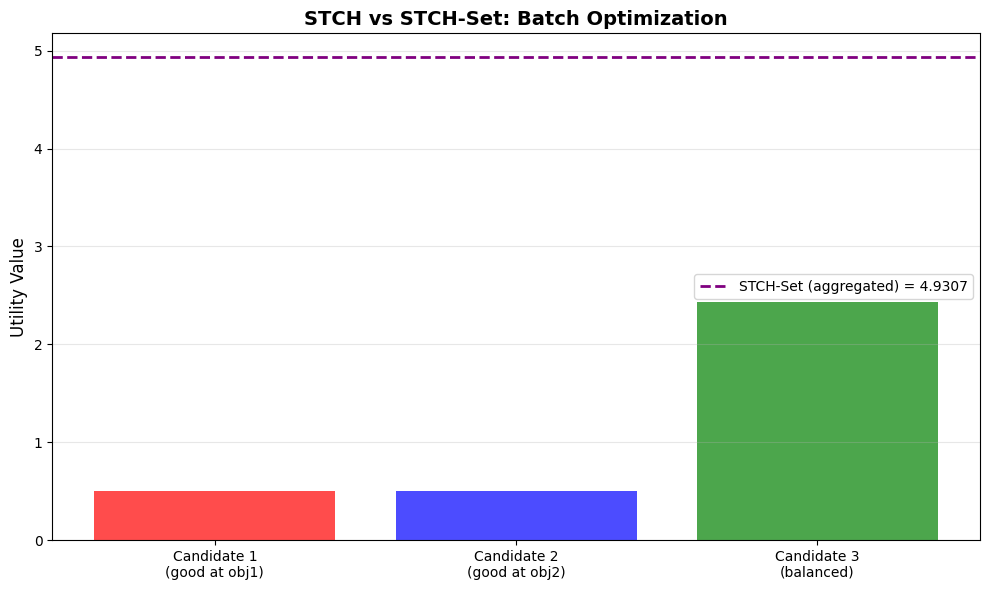


STCH-Set aggregates over the batch, optimizing for collective coverage!


In [ ]:
# Create a batch of candidates
# Each candidate excels at different objectives
Y_batch = torch.tensor([
    [[1.0, 10.0],   # Candidate 1: good at obj1, bad at obj2
     [10.0, 1.0],   # Candidate 2: bad at obj1, good at obj2
     [5.0, 5.0]]    # Candidate 3: balanced
])  # Shape: (1, 3, 2) = (batch, q, m)

weights = torch.tensor([0.5, 0.5])
ref_point = torch.tensor([0.0, 0.0])

# Standard STCH (per candidate)
stch_per_candidate = smooth_chebyshev(Y_batch.squeeze(0), weights, ref_point, mu=0.1)
print("STCH (per candidate):")
for i, val in enumerate(stch_per_candidate):
    print(f"  Candidate {i+1}: {val.item():.4f}")

# STCH-Set (aggregated over batch)
stch_set = smooth_chebyshev_set(Y_batch, weights, ref_point, mu=0.1)
print(f"\nSTCH-Set (aggregated): {stch_set.item():.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

candidates = ['Candidate 1\n(good at obj1)', 'Candidate 2\n(good at obj2)', 'Candidate 3\n(balanced)']
stch_vals = stch_per_candidate.numpy()

bars = ax.bar(candidates, stch_vals, alpha=0.7, color=['red', 'blue', 'green'])
ax.axhline(y=stch_set.item(), color='purple', linestyle='--', linewidth=2, 
           label=f'STCH-Set (aggregated) = {stch_set.item():.4f}')
ax.set_ylabel('Utility Value', fontsize=12)
ax.set_title('STCH vs STCH-Set: Batch Optimization', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSTCH-Set aggregates over the batch, optimizing for collective coverage!")


**Understanding the STCH-Set Aggregated Value**

STCH-Set combines multiple candidates into a set-level utility using smooth aggregation.
This is why the aggregated utility (~4.93) is much higher than individual candidate utilities 
(red ~0.5, blue ~0.5, green ~2.43).

Key insight: STCH-Set prefers solutions that work well collectively, not individually.
The aggregated value reflects how well the batch covers all objectives together.


## 5. BoTorch Integration Example

Here's how to use STCH objectives with BoTorch acquisition functions.


In [14]:
# Example: Using SmoothChebyshevObjective with BoTorch
# (This is a conceptual example - you would need a trained model in practice)

print("Example BoTorch Integration:")
print("=" * 50)

# Create objective
objective = SmoothChebyshevObjective(
    weights=torch.tensor([0.5, 0.5]),
    ref_point=torch.tensor([0.0, 0.0]),
    mu=0.1
)

print(f"Objective created: {type(objective).__name__}")
print(f"  Weights: {objective.weights}")
print(f"  Reference point: {objective.ref_point}")
print(f"  Smoothing parameter μ: {objective.mu}")

# Simulate MC samples (what BoTorch would pass)
# Shape: (sample_shape x batch_shape x q x m)
mc_samples = torch.randn(10, 1, 4, 2)  # 10 MC samples, 1 batch, 4 candidates, 2 objectives

# Forward pass
utilities = objective.forward(mc_samples)
print(f"\nInput shape: {mc_samples.shape}")
print(f"Output shape: {utilities.shape}")
print(f"  ✓ Correctly maps (..., q, m) → (..., q)")

# Example with STCH-Set
objective_set = SmoothChebyshevSetObjective(
    weights=torch.tensor([0.5, 0.5]),
    ref_point=torch.tensor([0.0, 0.0]),
    mu=0.1
)

utilities_set = objective_set.forward(mc_samples)
print(f"\nSTCH-Set Input shape: {mc_samples.shape}")
print(f"STCH-Set Output shape: {utilities_set.shape}")
print(f"  ✓ Correctly maps (..., q, m) → (...) [q dimension removed]")

print("\n" + "=" * 50)
print("Ready to use with:")
print("  - qLogNParEGO (with SmoothChebyshevObjective)")
print("  - qSimpleRegret (with SmoothChebyshevSetObjective)")
print("  - And other BoTorch acquisition functions!")


Example BoTorch Integration:
Objective created: SmoothChebyshevObjective
  Weights: tensor([0.5000, 0.5000])
  Reference point: tensor([0., 0.])
  Smoothing parameter μ: 0.1

Input shape: torch.Size([10, 1, 4, 2])
Output shape: torch.Size([10, 1, 4])
  ✓ Correctly maps (..., q, m) → (..., q)

STCH-Set Input shape: torch.Size([10, 1, 4, 2])
STCH-Set Output shape: torch.Size([10, 1])
  ✓ Correctly maps (..., q, m) → (...) [q dimension removed]

Ready to use with:
  - qLogNParEGO (with SmoothChebyshevObjective)
  - qSimpleRegret (with SmoothChebyshevSetObjective)
  - And other BoTorch acquisition functions!


## 6. Effect of Smoothing Parameter μ

Let's see how different values of μ affect the smoothness and approximation quality.


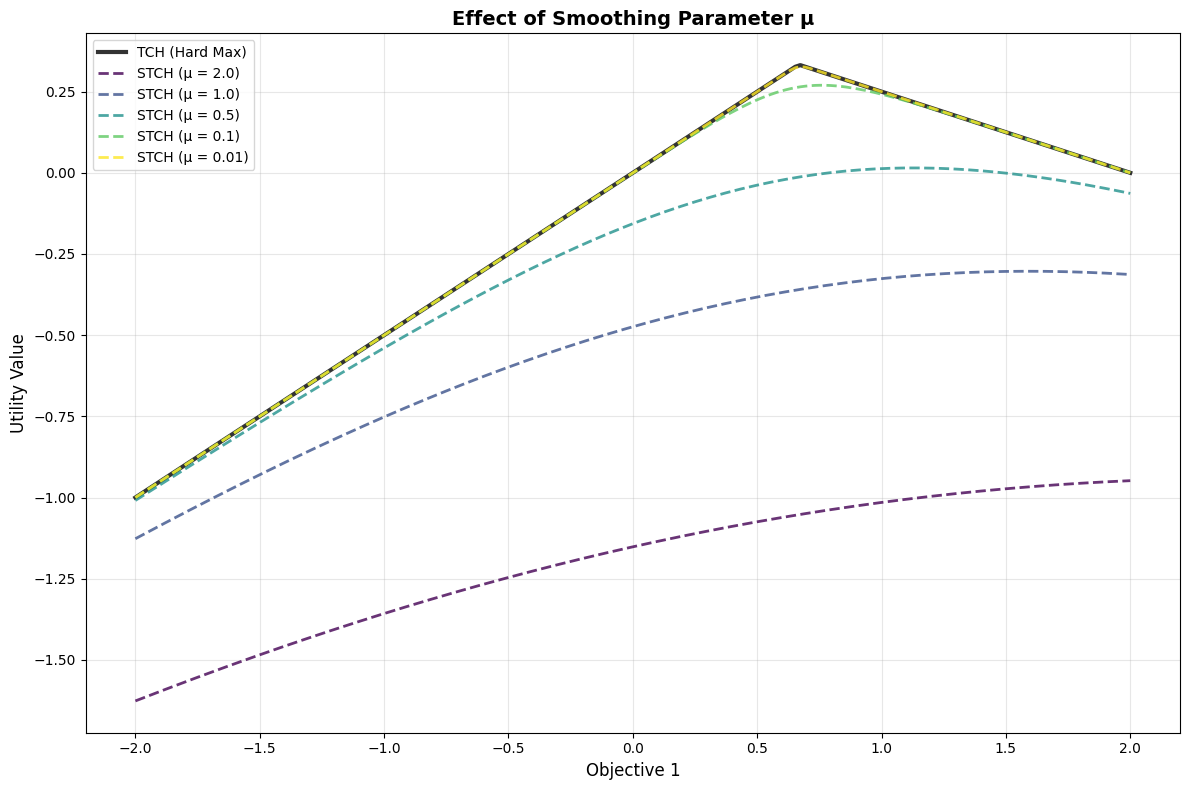

Observations:
  - Larger μ: Smoother, but less accurate approximation
  - Smaller μ: Tighter approximation to TCH, but less smooth
  - Default μ = 0.1: Good balance between smoothness and accuracy


In [15]:
# Create a 1D slice through the objective space
y1_vals = np.linspace(-2, 2, 200)
y2_vals = 1.0 - 0.5 * y1_vals  # Linear relationship

Y_slice = torch.tensor(np.stack([y1_vals, y2_vals], axis=1), dtype=torch.float32)
weights = torch.tensor([0.5, 0.5])
ref_point = torch.tensor([0.0, 0.0])

# Compute TCH
weighted_dist = weights * (ref_point - Y_slice)
tch_slice = -weighted_dist.max(dim=-1)[0].numpy()

# Compute STCH with different mu
mu_list = [2.0, 1.0, 0.5, 0.1, 0.01]
stch_slices = {}
for mu in mu_list:
    stch_slice = smooth_chebyshev(Y_slice, weights, ref_point, mu=mu)
    stch_slices[mu] = stch_slice.numpy()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(y1_vals, tch_slice, 'k-', linewidth=3, label='TCH (Hard Max)', alpha=0.8)

colors = plt.cm.viridis(np.linspace(0, 1, len(mu_list)))
for mu, color in zip(mu_list, colors):
    plt.plot(y1_vals, stch_slices[mu], '--', linewidth=2, 
             label=f'STCH (μ = {mu})', color=color, alpha=0.8)

plt.xlabel('Objective 1', fontsize=12)
plt.ylabel('Utility Value', fontsize=12)
plt.title('Effect of Smoothing Parameter μ', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observations:")
print("  - Larger μ: Smoother, but less accurate approximation")
print("  - Smaller μ: Tighter approximation to TCH, but less smooth")
print("  - Default μ = 0.1: Good balance between smoothness and accuracy")


## 7. SmoothChebyshevSetObjective: Batch Optimization Example

Let's see how `SmoothChebyshevSetObjective` can be used for batch optimization scenarios.


SmoothChebyshevSetObjective Batch Optimization Example

Standard STCH (evaluates each candidate separately):
  Candidate 1: utility = 0.2499
  Candidate 2: utility = 0.2499
  Candidate 3: utility = 0.4307
  Candidate 4: utility = 0.3970

STCH-Set (aggregates over batch for collective optimization):
  Batch utility: 0.9354


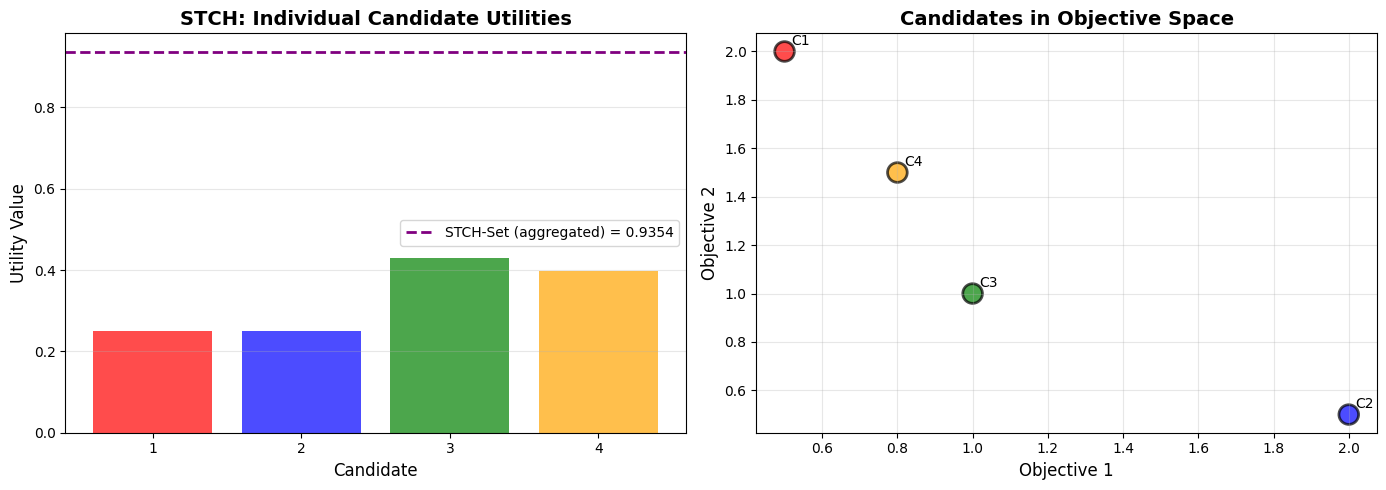


Key Insight:
  - STCH evaluates each candidate independently
  - STCH-Set optimizes the batch collectively for diverse coverage
  - Use STCH-Set when you want the batch to collectively cover all objectives


In [ ]:
# Example: Using SmoothChebyshevSetObjective for batch optimization
# This objective aggregates over the q dimension, optimizing for collective coverage

print("SmoothChebyshevSetObjective Batch Optimization Example")
print("=" * 60)

# Create a batch of candidates with different trade-offs
# Each candidate excels at different objectives
candidates_batch = torch.tensor([
    [0.5, 2.0],   # Candidate 1: good at obj1, worse at obj2
    [2.0, 0.5],   # Candidate 2: worse at obj1, good at obj2
    [1.0, 1.0],   # Candidate 3: balanced
    [0.8, 1.5],   # Candidate 4: slightly better at obj1
])  # Shape: (4, 2) = (q, m)

weights = torch.tensor([0.5, 0.5])
ref_point = torch.tensor([0.0, 0.0])

# Standard STCH (per candidate)
print("\nStandard STCH (evaluates each candidate separately):")
stch_per_candidate = smooth_chebyshev(candidates_batch, weights, ref_point, mu=0.1)
for i, val in enumerate(stch_per_candidate, 1):
    print(f"  Candidate {i}: utility = {val.item():.4f}")

# STCH-Set (aggregates over batch - optimizes for collective coverage)
print("\nSTCH-Set (aggregates over batch for collective optimization):")
# Need to add batch dimension: (q, m) -> (1, q, m)
candidates_batch_expanded = candidates_batch.unsqueeze(0)
stch_set = smooth_chebyshev_set(candidates_batch_expanded, weights, ref_point, mu=0.1)
print(f"  Batch utility: {stch_set.item():.4f}")

# Visualize the difference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Individual candidate utilities
ax1.bar(range(1, 5), stch_per_candidate.numpy(), alpha=0.7, color=['red', 'blue', 'green', 'orange'])
ax1.axhline(y=stch_set.item(), color='purple', linestyle='--', linewidth=2, 
           label=f'STCH-Set (aggregated) = {stch_set.item():.4f}')
ax1.set_xlabel('Candidate', fontsize=12)
ax1.set_ylabel('Utility Value', fontsize=12)
ax1.set_title('STCH: Individual Candidate Utilities', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, 5))
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')

# Right: Objective space visualization
ax2.scatter(candidates_batch[:, 0], candidates_batch[:, 1], 
           s=200, alpha=0.7, c=['red', 'blue', 'green', 'orange'], 
           edgecolors='black', linewidths=2)
ax2.set_xlabel('Objective 1', fontsize=12)
ax2.set_ylabel('Objective 2', fontsize=12)
ax2.set_title('Candidates in Objective Space', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add labels
for i, (x, y) in enumerate(candidates_batch, 1):
    ax2.annotate(f'C{i}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Key Insight:")
print("  - STCH evaluates each candidate independently")
print("  - STCH-Set optimizes the batch collectively for diverse coverage")
print("  - Use STCH-Set when you want the batch to collectively cover all objectives")
